In [1]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML
import os
import shutil
import glob 
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

class CocoCreator:
    # Assumes root_data_dir has both te GT and propagated segmentation labels
    def __init__(self, root_data_dir, segm_dir, semantic_json_root, instance_ids):
        self.rdd = root_data_dir
        self.sjr = semantic_json_root
        self.segm_dir = segm_dir
        self.instance_ids = instance_ids
        
    def create_coco(self, scene, coco_file_name, pct):
        hsd = self.load_semantic_json(scene)
        self.create_metadata(hsd)
        self.create_annos(hsd, scene, pct)
        self.save_json(coco_file_name)
        self.save_visual_dataset(coco_file_name, scene)
    
    def save_visual_dataset(self, coco_file_name, scene):
        DatasetCatalog.clear()
        MetadataCatalog.clear()

        register_coco_instances('foobar', {}, coco_file_name, os.path.join(self.rdd, 'rgb'))
        MetadataCatalog.get('foobar')
        dataset_dicts = DatasetCatalog.get('foobar')
        
        save_dir = os.path.join(self.segm_dir, 'coco_visuals')
        print(f'save_dir {save_dir}, coco_file_name {coco_file_name}')
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        for d in dataset_dicts:
            img = cv2.imread(d["file_name"])
            x = d['file_name'].split('/')[-1]
            print(f"filename {d['file_name'], x}, visual_file {os.path.join(save_dir, x)}")
            visualizer = Visualizer(img[:,:,::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            cv2.imwrite(os.path.join(save_dir, x), img)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.show()
        
    def save_json(self, coco_file_name):
        coco_output = {
            "info": self.INFO,
            "licenses": self.LICENSES,
            "categories": self.CATEGORIES,
            "images": self.IMAGES,
            "annotations": self.ANNOTATIONS,
        }
        print(f'self.CATS {self.CATEGORIES}')
        print(f"Dumping {len(coco_output['annotations'])} annotations to {coco_file_name}")
        with open(coco_file_name, "w") as output_json:
            json.dump(coco_output, output_json)
        
    def create_metadata(self, hsd):
        self.INFO = {}
        self.LICENSES = [{}]
        self.CATEGORIES = []
        self.IMAGES = []
        self.ANNOTATIONS = []
        self.class_id_label = {}
        for x in hsd['classes']:
            self.class_id_label[x['id']] = x['name']
        self.label_id_dict = {}
        self.new_old_id = {}
        idc = 1
        for i in self.instance_ids:
            instance_label = str(i) + '_' + self.class_id_label[hsd['id_to_label'][i]]
            print(f'instance_label {instance_label}')
            self.CATEGORIES.append({"id": idc, "name": instance_label, "supercategory": "shape"})
            self.label_id_dict[i] = instance_label # name the classes as instance_id + class 
            self.new_old_id[i] = idc
            idc += 1
    
    def create_annos(self, hsd, scene, pct):
        coco_img_id = -1
        count = 0
        segm_dir = self.segm_dir
        print(f"Scene {scene}, seg dir {segm_dir}")       
        img_dir = os.path.join(self.rdd, 'rgb')
        fs = self.get_segm_files(segm_dir, pct)
        print(f"Creating COCO annotations for {len(fs)} images \n img_dir {img_dir}")
        
        for f in tqdm(fs):
            image_id = int(f.split('.')[0])
            try:
                prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
                annot = np.load(prop_path).astype(np.uint32)
            except Exception as e:
                print(e)
                continue

            img_filename = "{:05d}.jpg".format(image_id)            
            img = Image.open(os.path.join(img_dir, img_filename))

            # COCO ID and names
            coco_img_id += 1

            image_info = pycococreatortools.create_image_info(
                coco_img_id, os.path.basename(img_filename), img.size
            )

            self.IMAGES.append(image_info)
            
#             print(f'unique annots {np.unique(annot.reshape(-1), axis=0)}')
            # for each annotation add to coco format
            for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                if i in self.instance_ids:
#                     print(f'{i} in {self.instance_ids}')
                    try:
                        if hsd["id_to_label"][i] < 1:# or hsd["id_to_label"][i] not in self.label_id_dict:
                            continue
                        category_info = {"id": self.new_old_id[i], "is_crowd": False}
    #                     print(f'category_info {category_info}')
                    except:
                        continue

                    binary_mask = (annot == i).astype(np.uint32)

                    annotation_info = pycococreatortools.create_annotation_info(
                        count, coco_img_id, category_info, binary_mask, img.size, tolerance=2
                    )
                    if annotation_info is not None:
                        self.ANNOTATIONS.append(annotation_info)
                        count += 1
#                         print(f'adding {len(annotation_info)} annotations')

        
    def load_semantic_json(self, scene):
        replica_root = '/datasets01/replica/061819/18_scenes'
        habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
        with open(habitat_semantic_json, "r") as f:
            hsd = json.load(f)
        if hsd is None:
            print("Semantic json not found!")
        return hsd
        
    def get_segm_files(self, segm_dir, pct):
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(segm_dir, '*.npy'))]
        cs.sort()
        frq = 1/pct
        fs = []
        for x in range(0, len(cs), int(frq)):
            fs.append(cs[x])
        return fs 

def run_coco(segm_dir, root_data_dir, pct, coco_name, instance_ids):
    cbase = CocoCreator(root_data_dir, segm_dir, semantic_json_root, instance_ids)
    cbase.create_coco(
        scene='apartment_0', 
        coco_file_name=os.path.join(root_data_dir, coco_name),
        pct=pct,
    )

In [2]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2021-11-16 15:01:05'

In [4]:
# combine everything into one folder 
from shutil import copyfile
import json

def acopyjson(a, b, c):
    with open(a, "r") as f:
        dat = json.load(f)
        
    with open(b, "r") as f:
        dat2 = json.load(f)
        
    ctr = len(dat.keys())
#     print(f'before {len(dat.keys()), len(dat2.keys())}')
    for k, v in dat2.items():
        dat[ctr] = v
        ctr += 1
    
#     print(f'after {len(dat.keys())}')
    with open(c, "w") as fp:
        json.dump(dat, fp)

def acopydir(a, b, c, ext):
    if not os.path.isdir(c):
        os.makedirs(c)
    
    fsa = [x for x in glob.glob(os.path.join(a, f'*{ext}'))]
    
    ctr = 0
    for f in fsa:
        fname = f.split('/')[-1]
        copyfile(f, os.path.join(c, fname))
        ctr += 1

    fsb = [x for x in glob.glob(os.path.join(b, f'*{ext}'))] 
    for f in fsb:
        fname = "{:05d}{}".format(ctr, ext)
        ctr += 1
        copyfile(f, os.path.join(c, fname))
    
#     print(f'acopydir {len(fsa), len(fsb)}')
    
    
def combine(traj_a, traj_b, traj_ab):
    if not os.path.isdir(traj_ab):
        os.makedirs(traj_ab)
    
    # copy over rgb, depth, seg from traj a
    # copy over rgb, d, seg from traj b but with new names 
    acopydir(os.path.join(traj_a, 'rgb'), os.path.join(traj_b, 'rgb'), os.path.join(traj_ab, 'rgb'), '.jpg')   
    acopydir(os.path.join(traj_a, 'depth'), os.path.join(traj_b, 'depth'), os.path.join(traj_ab, 'depth'), '.npy')
    acopydir(os.path.join(traj_a, 'seg'), os.path.join(traj_b, 'seg'), os.path.join(traj_ab, 'seg'), '.npy')
    acopyjson(os.path.join(traj_a, 'data.json'), os.path.join(traj_b, 'data.json'), os.path.join(traj_ab, 'data.json'))


ids_we_care_about = [243,404,196,133,166,170,172] #[404,196,133] #[193,404,196,172,243,133,129,170]

act_test = '/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2_test/active'
# def_test = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone_auto_test_2'
def_test = '/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2_test/baseline'

test_out = '/checkpoint/apratik/jobs/active_vision/pipeline/instance_det/apartment_0/test_1116_cvpr2'
combine(act_test, def_test, test_out)


  5%|▌         | 1/20 [00:00<00:02,  8.72it/s]

instance_label 243_door
instance_label 404_chair
instance_label 196_sofa
instance_label 133_chair
instance_label 166_book
instance_label 170_chair
instance_label 172_chair
Scene apartment_0, seg dir /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg
Creating COCO annotations for 20 images 
 img_dir /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


self.CATS [{'id': 1, 'name': '243_door', 'supercategory': 'shape'}, {'id': 2, 'name': '404_chair', 'supercategory': 'shape'}, {'id': 3, 'name': '196_sofa', 'supercategory': 'shape'}, {'id': 4, 'name': '133_chair', 'supercategory': 'shape'}, {'id': 5, 'name': '166_book', 'supercategory': 'shape'}, {'id': 6, 'name': '170_chair', 'supercategory': 'shape'}, {'id': 7, 'name': '172_chair', 'supercategory': 'shape'}]
Dumping 28 annotations to /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/coco_val.json
28 28
save_dir /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals, coco_file_name /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/coco_val.json
filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00000.jpg', '00000.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116

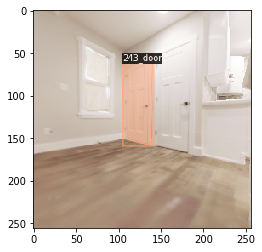

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00010.jpg', '00010.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00010.jpg


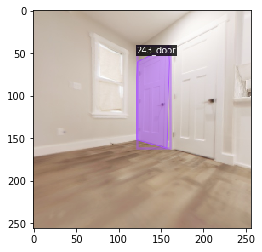

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00020.jpg', '00020.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00020.jpg


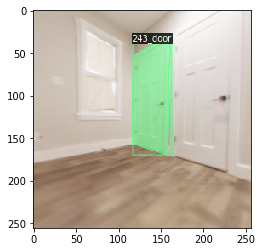

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00030.jpg', '00030.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00030.jpg


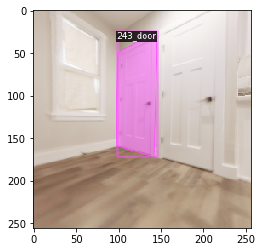

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00040.jpg', '00040.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00040.jpg


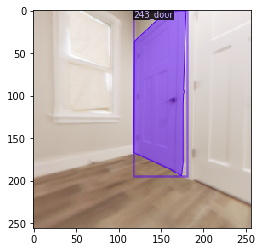

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00050.jpg', '00050.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00050.jpg


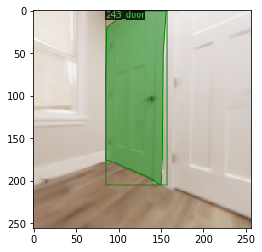

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00060.jpg', '00060.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00060.jpg


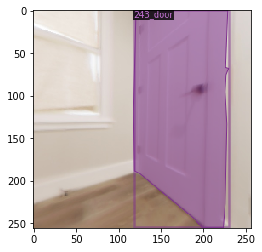

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00070.jpg', '00070.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00070.jpg


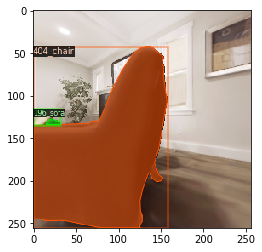

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00080.jpg', '00080.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00080.jpg


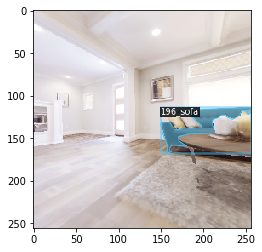

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00090.jpg', '00090.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00090.jpg


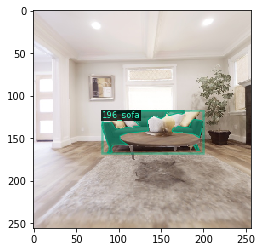

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00100.jpg', '00100.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00100.jpg


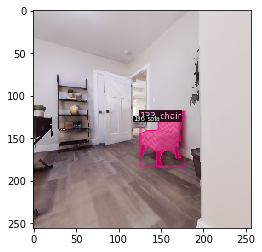

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00110.jpg', '00110.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00110.jpg


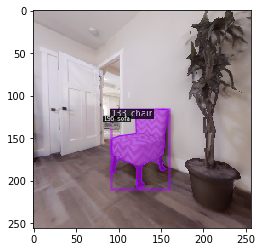

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00120.jpg', '00120.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00120.jpg


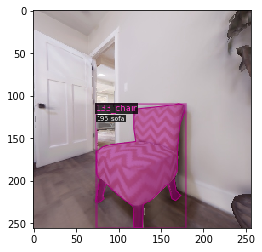

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00130.jpg', '00130.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00130.jpg


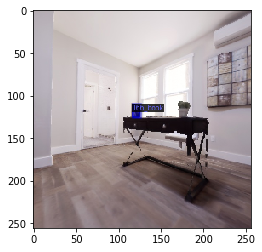

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00140.jpg', '00140.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00140.jpg


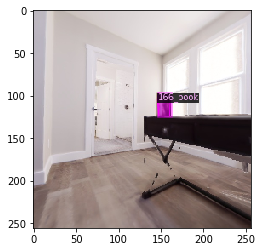

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00150.jpg', '00150.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00150.jpg


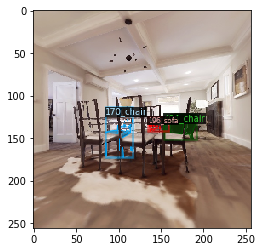

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00160.jpg', '00160.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00160.jpg


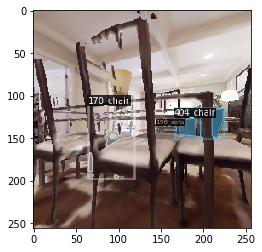

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00170.jpg', '00170.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00170.jpg


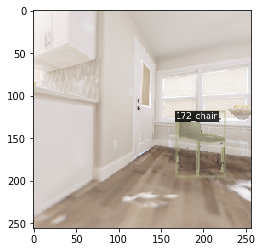

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00180.jpg', '00180.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00180.jpg


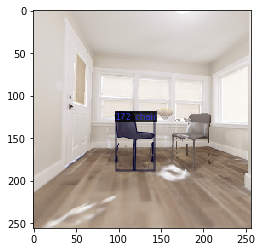

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/rgb/00190.jpg', '00190.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active/seg/coco_visuals/00190.jpg


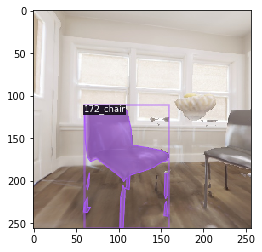

In [7]:
bdir = '/checkpoint/apratik/data_devfair0187/apartment_0/instance_det_sampled1_1116_cvpr2/active'
run_coco(os.path.join(bdir, 'seg'), bdir, 0.1, 'coco_val.json', ids_we_care_about)

 11%|█         | 1/9 [00:00<00:01,  6.80it/s]

instance_label 193_table
instance_label 404_chair
instance_label 196_sofa
instance_label 172_chair
instance_label 243_door
instance_label 133_chair
instance_label 129_vase
instance_label 170_chair
Scene apartment_0, seg dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg
Creating COCO annotations for 9 images 
 img_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb
170 in [193, 404, 196, 172, 243, 133, 129, 170]
193 in [193, 404, 196, 172, 243, 133, 129, 170]
243 in [193, 404, 196, 172, 243, 133, 129, 170]
404 in [193, 404, 196, 172, 243, 133, 129, 170]


 33%|███▎      | 3/9 [00:00<00:00,  6.84it/s]

133 in [193, 404, 196, 172, 243, 133, 129, 170]
193 in [193, 404, 196, 172, 243, 133, 129, 170]
196 in [193, 404, 196, 172, 243, 133, 129, 170]
193 in [193, 404, 196, 172, 243, 133, 129, 170]
196 in [193, 404, 196, 172, 243, 133, 129, 170]
404 in [193, 404, 196, 172, 243, 133, 129, 170]


 56%|█████▌    | 5/9 [00:00<00:00,  6.78it/s]

170 in [193, 404, 196, 172, 243, 133, 129, 170]
243 in [193, 404, 196, 172, 243, 133, 129, 170]
172 in [193, 404, 196, 172, 243, 133, 129, 170]


 78%|███████▊  | 7/9 [00:01<00:00,  6.61it/s]

404 in [193, 404, 196, 172, 243, 133, 129, 170]
133 in [193, 404, 196, 172, 243, 133, 129, 170]
193 in [193, 404, 196, 172, 243, 133, 129, 170]
196 in [193, 404, 196, 172, 243, 133, 129, 170]


100%|██████████| 9/9 [00:01<00:00,  6.60it/s]

193 in [193, 404, 196, 172, 243, 133, 129, 170]
196 in [193, 404, 196, 172, 243, 133, 129, 170]
404 in [193, 404, 196, 172, 243, 133, 129, 170]
193 in [193, 404, 196, 172, 243, 133, 129, 170]
196 in [193, 404, 196, 172, 243, 133, 129, 170]
404 in [193, 404, 196, 172, 243, 133, 129, 170]
Dumping 23 annotations to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/coco_train.json


23 23
save_dir /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals, coco_file_name /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/coco_train.json
filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/00000.jpg', '00000.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/00000.jpg


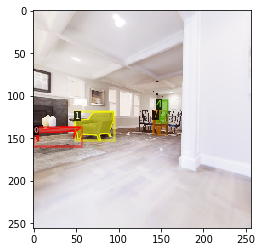

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/02395.jpg', '02395.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/02395.jpg


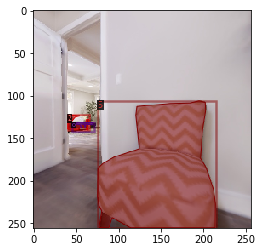

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/03064.jpg', '03064.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/03064.jpg


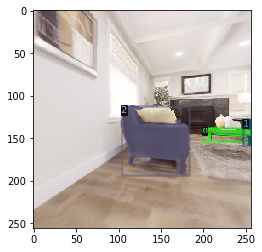

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/03995.jpg', '03995.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/03995.jpg


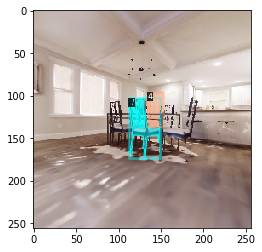

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/04466.jpg', '04466.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/04466.jpg


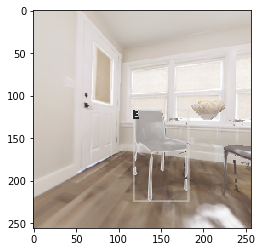

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/05320.jpg', '05320.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/05320.jpg


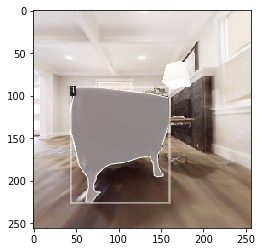

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/07056.jpg', '07056.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/07056.jpg


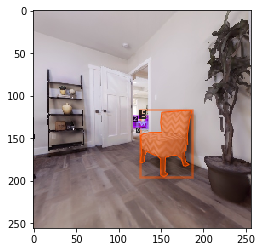

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/08519.jpg', '08519.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/08519.jpg


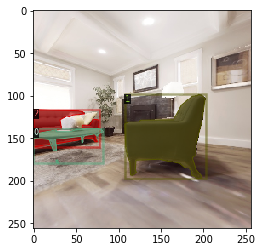

filename ('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/rgb/10630.jpg', '10630.jpg'), visual_file /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone/seg/coco_visuals/10630.jpg


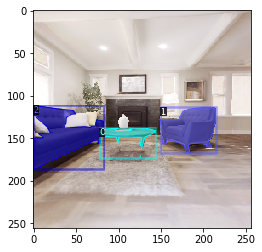